In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "lampe01" # username from the json file
os.environ['KAGGLE_KEY'] = "0fe21bb583c2cd3230e9d928c96e27f7" # key from the json file
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/KaggleHeartSoundsDataset"

In [3]:
%cd /content/drive/MyDrive/KaggleHeartSoundsDataset

/content/drive/MyDrive/KaggleHeartSoundsDataset


In [4]:
pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
pip install ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
%matplotlib inline
%pylab inline
%config InlineBackend.figure_format = 'retina'
import IPython.display as ipd
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import math
from os import path
from pydub import AudioSegment
from scipy.io import wavfile
from livelossplot import PlotLossesKeras
import fnmatch
import sklearn.metrics
import sklearn.model_selection
import sklearn.linear_model
import sklearn.preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from numpy import dstack
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dropout, Activation, Flatten, LSTM
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import itertools
from keras.wrappers.scikit_learn import KerasClassifier

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [9]:
indir = "/content/drive/MyDrive/KaggleHeartSoundsDataset"
Srate = 16000
MaxDuration = 12

In [10]:
A = pd.read_csv(indir+'/set_a.csv')
Atime = pd.read_csv(indir+'/set_a_timing.csv')
B = pd.read_csv(indir+'/set_b.csv')

In [11]:
sets1 = [A, B]
AB = pd.concat(sets1)

In [12]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5

#get audio data without padding highest qualify audio
def load_file_data_without_change(folder,file_names, duration=3, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load(sound_file, res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=27).T,axis=0)
            rms = librosa.feature.rms(x, frame_length=512, hop_length=256, center=True) 
        except Exception as e:
            print("Error encountered while parsing file: ", file_name)
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
        f2 = np.array(rms).reshape([-1,1])
        data.append(f2)
    return data

In [13]:
def load_file_data (folder,file_names, duration=12, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load(sound_file, sr=sr, duration=duration,res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                print ("fixing audio lenght :", file_name)
                y = librosa.util.fix_length(X, input_length)                
            #normalized raw audio 
            # y = audio_norm(y)            
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=27).T,axis=0)
            rms = np.mean(librosa.feature.rms(y = X, frame_length=512, hop_length=256, center=True).T,axis=0)             
        except Exception as e:
            print("Error encountered while parsing file: ", file_name)        
        feature = np.array(mfccs).reshape([-1,1])
        f2 = np.array(rms).reshape([-1,1])
        data.append(feature)
    return data

In [14]:
#Map label text to integer
Classes = ['artifact','murmur','normal']
# {'artifact': 0, 'murmur': 1, 'normal': 3}
nclasses = len(Classes)

#Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(Classes)}
print (label_to_int)
print (" ")
#map integer to label text
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'artifact': 0, 'murmur': 1, 'normal': 2}
 
{0: 'artifact', 1: 'murmur', 2: 'normal'}


In [15]:
A1 = indir+'/set_a/'
# set-a
A_artifact_files = fnmatch.filter(os.listdir(indir+'/set_a'), 'artifact*.wav')
A_artifact_sounds = load_file_data(folder=A1,file_names=A_artifact_files, duration=MaxDuration)
A_artifact_labels = [0 for items in A_artifact_files]

A_normal_files = fnmatch.filter(os.listdir(indir+'/set_a'), 'normal*.wav')
A_normal_sounds = load_file_data(folder=A1,file_names=A_normal_files, duration=MaxDuration)
A_normal_labels = [2 for items in A_normal_sounds]

A_extrahls_files = fnmatch.filter(os.listdir(indir+'/set_a'), 'extrahls*.wav')
A_extrahls_sounds = load_file_data(folder=A1,file_names=A_extrahls_files, duration=MaxDuration)
A_extrahls_labels = [1 for items in A_extrahls_sounds]

A_murmur_files = fnmatch.filter(os.listdir(indir+'/set_a'), 'murmur*.wav')
A_murmur_sounds = load_file_data(folder=A1,file_names=A_murmur_files, duration=MaxDuration)
A_murmur_labels = [1 for items in A_murmur_files]

# test files
A_unlabelledtest_files = fnmatch.filter(os.listdir(indir+'/set_a'), 'Aunlabelledtest*.wav')
A_unlabelledtest_sounds = load_file_data(folder=A1,file_names=A_unlabelledtest_files, duration=MaxDuration)
A_unlabelledtest_labels = [-1 for items in A_unlabelledtest_sounds]

print ("loaded dataset-a")

load file  /content/drive/MyDrive/KaggleHeartSoundsDataset/set_a/artifact__201012172012.wav
fixing audio lenght : artifact__201012172012.wav
load file  /content/drive/MyDrive/KaggleHeartSoundsDataset/set_a/artifact__201105041959.wav
fixing audio lenght : artifact__201105041959.wav
load file  /content/drive/MyDrive/KaggleHeartSoundsDataset/set_a/artifact__201105040918.wav
fixing audio lenght : artifact__201105040918.wav
load file  /content/drive/MyDrive/KaggleHeartSoundsDataset/set_a/artifact__201105051017.wav
fixing audio lenght : artifact__201105051017.wav
load file  /content/drive/MyDrive/KaggleHeartSoundsDataset/set_a/artifact__201105060108.wav
fixing audio lenght : artifact__201105060108.wav
load file  /content/drive/MyDrive/KaggleHeartSoundsDataset/set_a/artifact__201105061143.wav
fixing audio lenght : artifact__201105061143.wav
load file  /content/drive/MyDrive/KaggleHeartSoundsDataset/set_a/artifact__201105190800.wav
fixing audio lenght : artifact__201105190800.wav
load file  /c

In [16]:
%%time
# load dataset-b, keep them separate for testing purpose 
B1 = indir+'/set_b/'
# set-b
B_normal_files = fnmatch.filter(os.listdir(indir+'/set_b'), 'normal*.wav')  # include noisy files
B_normal_sounds = load_file_data(folder=B1,file_names=B_normal_files, duration=MaxDuration)
B_normal_labels = [2 for items in B_normal_sounds]

B_murmur_files = fnmatch.filter(os.listdir(indir+'/set_b'), 'murmur*.wav')  # include noisy files
B_murmur_sounds = load_file_data(folder=B1,file_names=B_murmur_files, duration=MaxDuration)
B_murmur_labels = [1 for items in B_murmur_files]

B_extrastole_files = fnmatch.filter(os.listdir(indir+'/set_b'), 'extrastole*.wav')
B_extrastole_sounds = load_file_data(folder=B1,file_names=B_extrastole_files, duration=MaxDuration)
B_extrastole_labels = [1 for items in B_extrastole_files]

#test files
B_unlabelledtest_files = fnmatch.filter(os.listdir(indir+'/set_b'), 'Bunlabelledtest*.wav')
B_unlabelledtest_sounds = load_file_data(folder=B1,file_names=B_unlabelledtest_files, duration=MaxDuration)
B_unlabelledtest_labels = [-1 for items in B_unlabelledtest_sounds]
print ("loaded dataset-b")

load file  /content/drive/MyDrive/KaggleHeartSoundsDataset/set_b/normal__103_1305031931979_B.wav
fixing audio lenght : normal__103_1305031931979_B.wav
load file  /content/drive/MyDrive/KaggleHeartSoundsDataset/set_b/normal__103_1305031931979_D1.wav
fixing audio lenght : normal__103_1305031931979_D1.wav
load file  /content/drive/MyDrive/KaggleHeartSoundsDataset/set_b/normal__103_1305031931979_D2.wav
fixing audio lenght : normal__103_1305031931979_D2.wav
load file  /content/drive/MyDrive/KaggleHeartSoundsDataset/set_b/normal__103_1305031931979_D3.wav
fixing audio lenght : normal__103_1305031931979_D3.wav
load file  /content/drive/MyDrive/KaggleHeartSoundsDataset/set_b/normal__106_1306776721273_B1.wav
fixing audio lenght : normal__106_1306776721273_B1.wav
load file  /content/drive/MyDrive/KaggleHeartSoundsDataset/set_b/normal__106_1306776721273_C1.wav
fixing audio lenght : normal__106_1306776721273_C1.wav
load file  /content/drive/MyDrive/KaggleHeartSoundsDataset/set_b/normal__106_1306776

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


load file  /content/drive/MyDrive/KaggleHeartSoundsDataset/set_b/normal__127_1306764300147_A.wav
fixing audio lenght : normal__127_1306764300147_A.wav
load file  /content/drive/MyDrive/KaggleHeartSoundsDataset/set_b/normal__127_1306764300147_B.wav
fixing audio lenght : normal__127_1306764300147_B.wav
load file  /content/drive/MyDrive/KaggleHeartSoundsDataset/set_b/normal__128_1306344005749_D.wav
fixing audio lenght : normal__128_1306344005749_D.wav
load file  /content/drive/MyDrive/KaggleHeartSoundsDataset/set_b/normal__128_1306344005749_B.wav
fixing audio lenght : normal__128_1306344005749_B.wav
load file  /content/drive/MyDrive/KaggleHeartSoundsDataset/set_b/normal__127_1306764300147_C1.wav
fixing audio lenght : normal__127_1306764300147_C1.wav
load file  /content/drive/MyDrive/KaggleHeartSoundsDataset/set_b/normal__129_1306344506305_B1.wav
fixing audio lenght : normal__129_1306344506305_B1.wav
load file  /content/drive/MyDrive/KaggleHeartSoundsDataset/set_b/normal__128_1306344005749

In [17]:
x = np.concatenate((A_artifact_sounds, A_normal_sounds,A_extrahls_sounds,A_murmur_sounds, 
                         B_normal_sounds,B_murmur_sounds,B_extrastole_sounds))
#x.reset_index(drop=True)
y = np.concatenate((A_artifact_labels, A_normal_labels,A_extrahls_labels,A_murmur_labels,
                         B_normal_labels,B_murmur_labels,B_extrastole_labels))

In [18]:
x.shape

(585, 27, 1)

In [19]:
#x = x.reshape([-1, 1])
#x.shape

In [20]:
y.shape

(585,)

In [21]:
from tensorflow import keras

xtest = np.concatenate((A_unlabelledtest_sounds,B_unlabelledtest_sounds))
ytest = np.concatenate((A_unlabelledtest_labels,B_unlabelledtest_labels))

# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9, shuffle=True)

y_train = np.array(keras.utils.to_categorical(y_train, len(Classes)))
y_test = np.array(keras.utils.to_categorical(y_test, len(Classes)))
ytest=np.array(keras.utils.to_categorical(ytest, len(Classes)))

In [22]:
x_train.shape

(526, 27, 1)

In [26]:
input_shape = (27,1)

from keras.wrappers.scikit_learn import KerasClassifier

def DL_Model(activation= 'relu', neurons= 64, optimizer='Adam'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=x_train.shape[1], activation= activation))
    model.add(Dense(neurons, activation= activation))
    model.add(Dropout(0.3))
    model.add(Dense(len(Classes), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])
    return model

# Definying grid parameters
activation = ['softmax', 'relu', 'tanh']
neurons = [32, 64, 128, 256, 512]
optimizer = ['SGD', 'Adam', 'Adamax']
param_grid = dict(activation = activation, neurons = neurons, optimizer = optimizer)

clf = KerasClassifier(build_fn= DL_Model, epochs= 80, batch_size=40, verbose= 0)

model = GridSearchCV(estimator= clf, param_grid=param_grid, n_jobs=-1)
model.fit(x_train, y_train)

print("Max Accuracy Registred: {} using {}".format(round(model.best_score_,3), 
                                                   model.best_params_))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Max Accuracy Registred: 0.741 using {'activation': 'relu', 'neurons': 256, 'optimizer': 'Adamax'}


In [28]:
#history = model.fit(x_train, y_train, batch_size=50 ,epochs=200,  validation_split = 0.2, verbose=1).history
model = Sequential()
model.add(Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(Classes), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer= 'Adamax', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=50 ,epochs=200,  validation_split = 0.2, verbose=1).history

Epoch 1/200
9/9 [==============================] - 1s 30ms/step - loss: 14.3688 - accuracy: 0.4762 - val_loss: 5.7860 - val_accuracy: 0.6226
Epoch 2/200
9/9 [==============================] - 0s 5ms/step - loss: 9.7085 - accuracy: 0.5500 - val_loss: 2.7998 - val_accuracy: 0.7075
Epoch 3/200
9/9 [==============================] - 0s 6ms/step - loss: 5.8183 - accuracy: 0.5595 - val_loss: 2.3421 - val_accuracy: 0.7453
Epoch 4/200
9/9 [==============================] - 0s 6ms/step - loss: 5.6740 - accuracy: 0.5500 - val_loss: 1.7801 - val_accuracy: 0.7075
Epoch 5/200
9/9 [==============================] - 0s 5ms/step - loss: 4.6298 - accuracy: 0.6190 - val_loss: 2.0700 - val_accuracy: 0.7264
Epoch 6/200
9/9 [==============================] - 0s 6ms/step - loss: 3.7359 - accuracy: 0.6071 - val_loss: 1.5881 - val_accuracy: 0.7170
Epoch 7/200
9/9 [==============================] - 0s 6ms/step - loss: 3.0339 - accuracy: 0.6095 - val_loss: 1.2990 - val_accuracy: 0.7075
Epoch 8/200
9/9 [========

In [30]:
score = model.evaluate(xtest, ytest, verbose=0) 
print ("model unlabelled data score : ",round(score[1]*100) , "%")

model unlabelled data score :  82 %


In [32]:
y_predict = np.argmax(model.predict(x_test), axis=-1)
y_pred = model.predict(x_test)

In [33]:
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
confusion_matrix(y_test, y_pred)

array([[ 2,  0,  1],
       [ 0,  6, 14],
       [ 0,  2, 34]])

In [34]:
print("Classification Report : \n\n", classification_report(y_test, y_pred))

Classification Report : 

               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      0.30      0.43        20
           2       0.69      0.94      0.80        36

    accuracy                           0.71        59
   macro avg       0.81      0.64      0.68        59
weighted avg       0.73      0.71      0.67        59



In [36]:
print(confusion_matrix(y_test,y_pred))

[[ 2  0  1]
 [ 0  6 14]
 [ 0  2 34]]


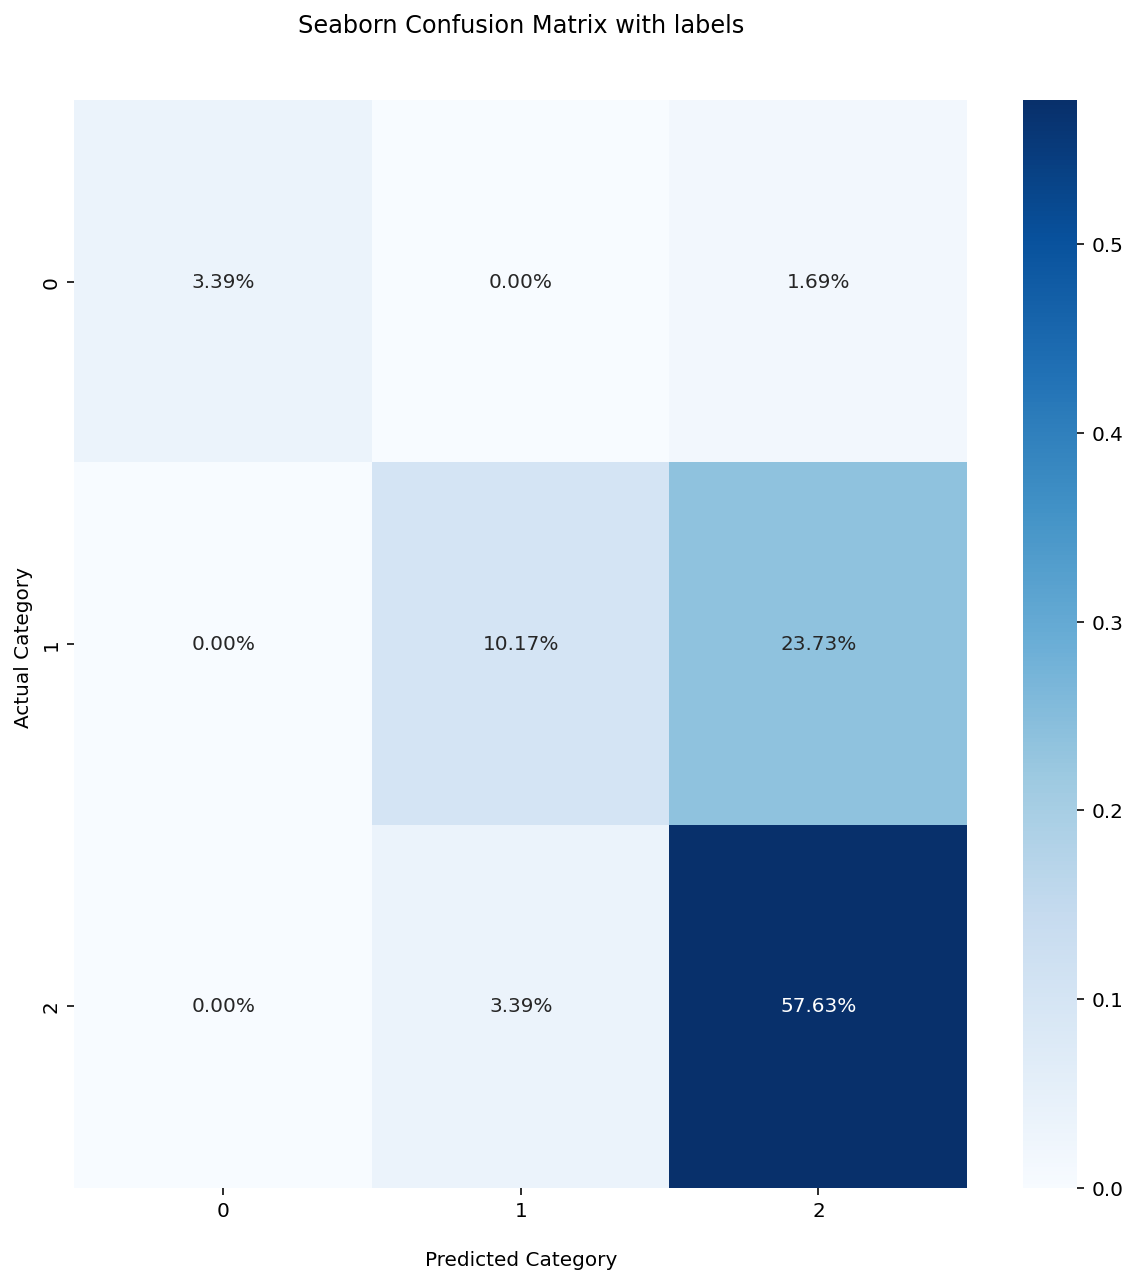

In [38]:
cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues', ax=ax)

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Display the visualization of the Confusion Matrix.
plt.show()

In [41]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 8.1 MB/s 


In [49]:
import kerastuner
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
def model_builder(hp):
  model = Sequential()
  hp_units1 = hp.Int('units_', min_value=32, max_value=512, step=32)
  model.add(tf.keras.layers.Dense(units = hp_units1, input_dim = x_train.shape[1]))

  # Tune the number of dense layers
  for i in range(hp.Int('num_layers', 1, 6)):
    
    # Tune the number of units in the each dense layer
    hp_units = hp.Int('units_'+str(i), min_value=32, max_value=512, step=32)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
    
    # Tune the dropout rate in the each dense layer
    hp_dropout = hp.Float('rate', min_value=0.0, max_value=0.5, step=0.1)
    model.add(tf.keras.layers.Dropout(hp_dropout))
    
  # Add dense output layer
  model.add(tf.keras.layers.Dense(len(Classes), activation='softmax'))

  # Tune the learning rate for the optimizer
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

tuner = Hyperband(model_builder,
objective='val_accuracy',
max_epochs=100,
factor=3,
overwrite=True)

tuner.search(x_train,y_train, epochs=100, validation_split=0.2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)

Trial 254 Complete [00h 00m 22s]
val_accuracy: 0.698113203048706

Best val_accuracy So Far: 0.801886796951294
Total elapsed time: 00h 12m 42s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [50]:
history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose = 1)

Epoch 1/100
14/14 [==============================] - 1s 25ms/step - loss: 3.7251 - accuracy: 0.5000 - val_loss: 0.9893 - val_accuracy: 0.6981
Epoch 2/100
14/14 [==============================] - 0s 7ms/step - loss: 2.3704 - accuracy: 0.4905 - val_loss: 1.0062 - val_accuracy: 0.7075
Epoch 3/100
14/14 [==============================] - 0s 7ms/step - loss: 2.0671 - accuracy: 0.4786 - val_loss: 0.9334 - val_accuracy: 0.7170
Epoch 4/100
14/14 [==============================] - 0s 7ms/step - loss: 1.6642 - accuracy: 0.5714 - val_loss: 0.8409 - val_accuracy: 0.4906
Epoch 5/100
14/14 [==============================] - 0s 8ms/step - loss: 1.5929 - accuracy: 0.5548 - val_loss: 0.6585 - val_accuracy: 0.7642
Epoch 6/100
14/14 [==============================] - 0s 8ms/step - loss: 1.2476 - accuracy: 0.5619 - val_loss: 0.8168 - val_accuracy: 0.7170
Epoch 7/100
14/14 [==============================] - 0s 9ms/step - loss: 1.1600 - accuracy: 0.5381 - val_loss: 0.7228 - val_accuracy: 0.7264
Epoch 8/100


In [51]:
score = model.evaluate(xtest, ytest, verbose=0) 
print ("model unlabelled data score : ",round(score[1]*100) , "%")

model unlabelled data score :  80 %


In [53]:
y_predict = np.argmax(model.predict(x_test), axis=-1)
y_pred = model.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
#y_test=np.argmax(y_test, axis=1)
confusion_matrix(y_test, y_pred)

array([[ 3,  0,  0],
       [ 0,  4, 16],
       [ 0,  3, 33]])

In [54]:
print("Classification Report : \n\n", classification_report(y_test, y_pred))

Classification Report : 

               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.57      0.20      0.30        20
           2       0.67      0.92      0.78        36

    accuracy                           0.68        59
   macro avg       0.75      0.71      0.69        59
weighted avg       0.66      0.68      0.63        59



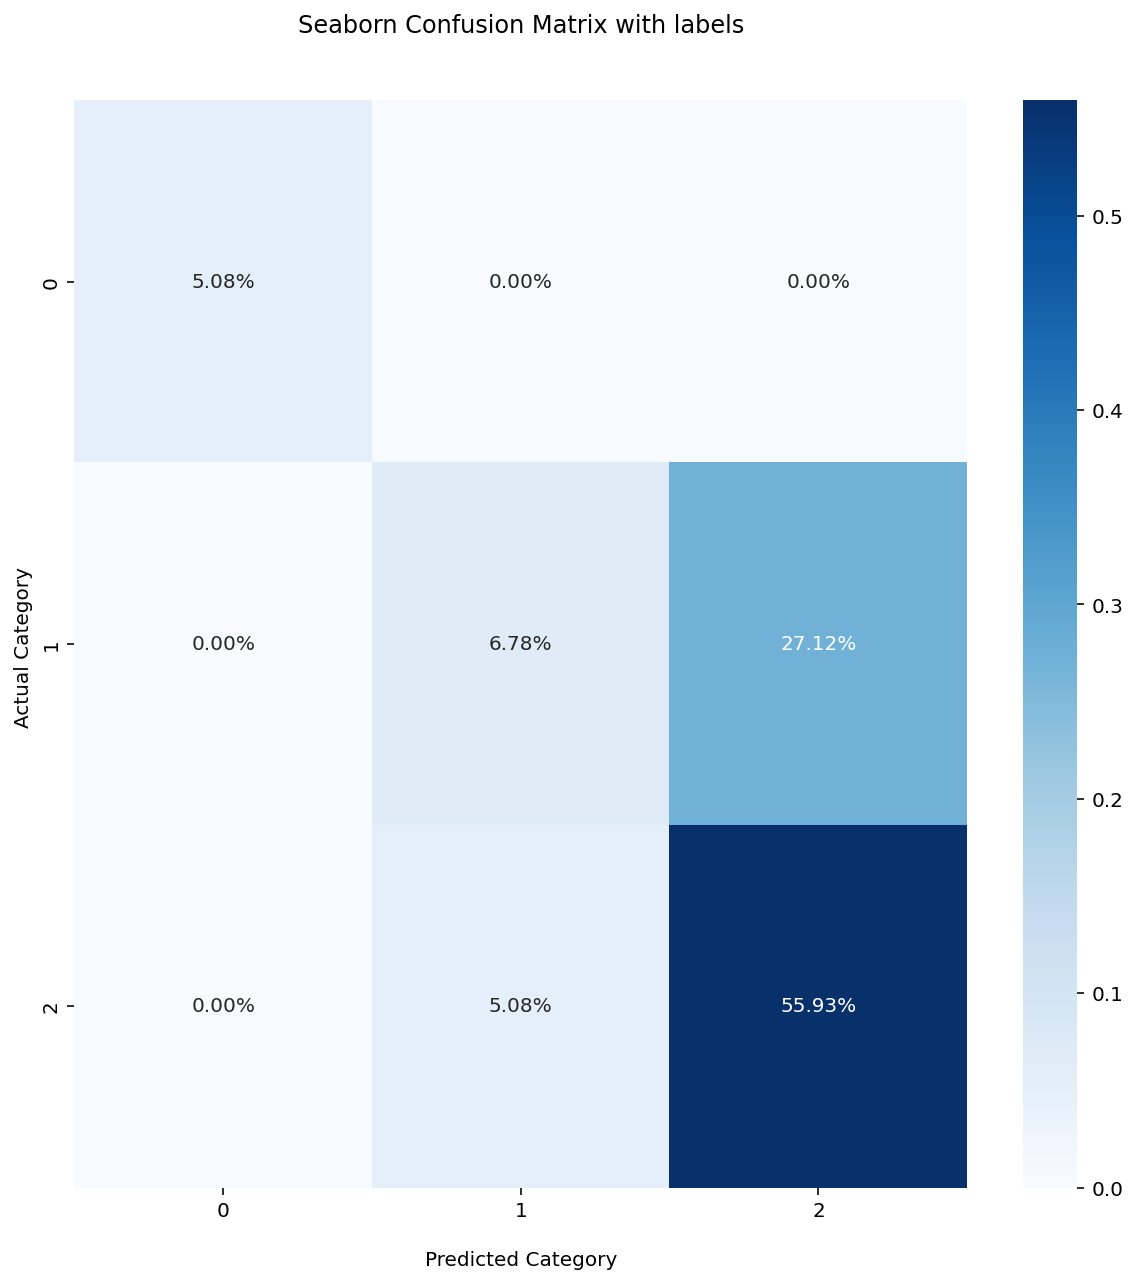

In [55]:
cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues', ax=ax)

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Display the visualization of the Confusion Matrix.
plt.show()